<a href="https://colab.research.google.com/github/xoxominji/22-1-ESAA-Practice/blob/main/0509_session_%EB%B0%95%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 소설 작가 분류 AI 경진대회

## 4. Word Embedding

- 앞에서 살펴보았던 vectorization의 치명적인 단점은 바로 단어나 문장들 사이의 관계에 대해서 설명하지 못한다는 것입니다.

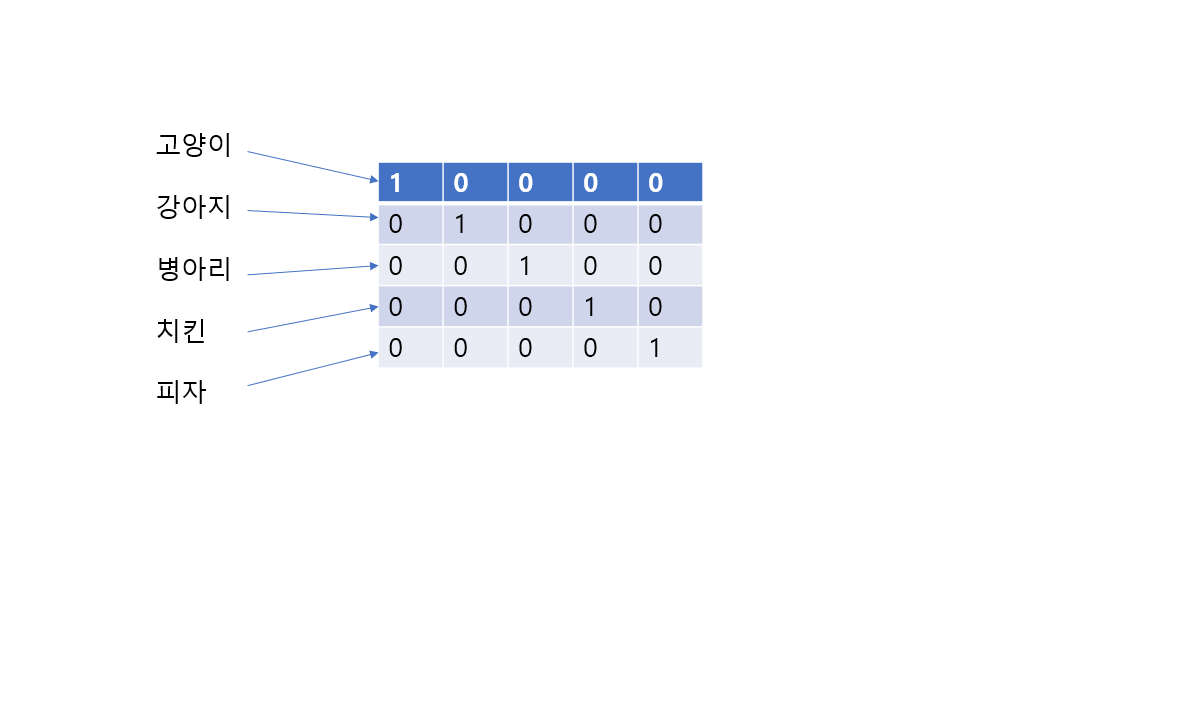

- one hot encoding을 통해 각 5개의 토큰들이 고유의 벡터를 갖게 되었습니다. 하지만 뭔가 이상하지 않나요? 사람이 보기에는 5개의 토큰들이 너무나도 명확하게 구분 됩니다. 지금까지 살펴 본 벡터화 방법들은 단어의 중요도나 문서 안에서의 중요도는 구분 할 수 있지만 단어 사이의 유사도는 구별할 수 없었습니다.

- 이 때 사용되는 것이 Embedding 기법이며 word2vec을 비롯한 다양한 임베딩 기법들이 존재합니다. 대략적인 아이디어는 다음과 같습니다.

- 유사한 토큰들은 가깝게 임의의 차원에 뿌린다.

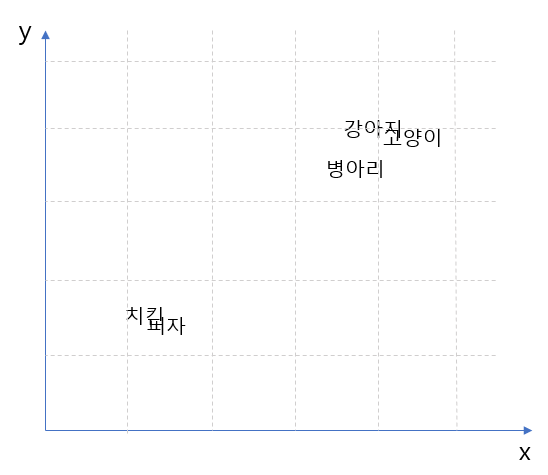

- 위의 예시처럼 비슷한 의미를 내포하고 있는 토큰들은 서로 가깝게, 그렇지 않은 토큰들은 서로 멀리 뿌리도록 하는 것이 임베딩의 목적입니다. 검색 시스템, 감성 분석 등에서는 훌륭한 임베딩을 수행하는 것이 전체 문제 해결에 많은 영향을 줍니다.

- 임베딩 또한 하나의 모델을 의미하며 훈련이 필요합니다. 데이터가 충분하고 시간이 많으면 소지한 데이터에 특화된 임베딩 모델을 학습시킬 수 있습니다. 보통은 `pre_trained embedding model`을 가져와서 사용합니다.

### **1) Keras Embedding Layer**
- 기본적으로 가장 쉽고 빠르게 네트워크 모델에 임베딩 층을 주입할 수 있는 방식입니다. 이 방법은 무작위로 특정 차원으로 입력 벡터들을 뿌린 후 학습을 통해 가중치들을 조정해 나가는 방식입니다. 즉, 단어 사이의 관계를 반영하는 방법이 아닙니다.

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer() #keras의 vectorizing 함수 호출
    tokenizer.fit_on_texts(train_text) #train 문장에 fit
    train_X_seq = tokenizer.texts_to_sequences(train_text) #각 토큰들에 정수 부여
    vocabulary = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1 #모델에 알려줄 vocabulary의 크기 계산
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len) #설정한 문장의 최대 길이만큼 padding
    
    return X_train, vocab_size, tokenizer, vocabulary

In [29]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/데이터/소설 작가 분류/train.csv')

train_X, vocab_size, vectorizer, vocabulary = text2sequence(train['text'], max_len = 100)

vocab_size :  42331


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = 100))

### **2) word2vec**

- word2vec의 핵심 아이디어는 "친구를 보면 그 사람을 알 수 있다"입니다. 주변 단어와의 관계를 통해 해당 단어의 의미적 특성을 파악합니다.

In [31]:
# gensim 모듈과 bin파일을 활용해 word2vec 모델 로드
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/2022-1 ESAA/데이터/GoogleNews-vectors-negative300.bin', binary=True)

In [51]:
# vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장합니다.

import numpy as np
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_matrix에 저장합니다.
    else:
        print("word2vec에 없는 단어입니다.")
        break

word2vec에 없는 단어입니다.


In [52]:
# keras embedding layer에 embedding_matrix를 가중치로 주어 이용합니다.
model = Sequential()
model.add(Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = 100))

### **3) glove**

- glove는 word2vec의 단점을 보완하기 위하여 등장하였습니다. word2vec이 사용자가 지정한 주변 단어의 개수에 대해서만 학습이 이루어지기 때문에 데이터 전체에 대한 정보를 담기 어렵다는 단점을 지적하였습니다. 

- glove의 핵심 아이디어는 다음과 같습니다: 각 토큰들 간의 유사성은 그대로 가져가면서 데이터 전체에 대한 빈도를 반영하자.

glove embedding matrix를 keras의 embedding matrix에 주입하는 방법은 다음과 같습니다.

In [55]:
# load the whole embedding into memory
glove = dict()
f = open('/content/drive/MyDrive/2022-1 ESAA/데이터/glove.txt')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove[word] = vector
f.close()

In [57]:
# vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장합니다.
embedding_matrix = np.zeros((vocab_size, 100)) #100차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in glove: #넘겨 받은 토큰이 glove에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = glove[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_matrix에 저장합니다.
    else:
        print("glove 없는 단어입니다.")
        break

glove 없는 단어입니다.


In [59]:
#keras embedding layer에 embedding_matrix를 가중치로 주어 이용합니다.
model = Sequential()
model.add(Embedding(vocab_size, 100, weights = [embedding_matrix], input_length = 100))

### **4) Fasttext**

- Fasttext의 핵심 아이디어는 단어 단위가 아닌 sub 단어를 단위로 사용합니다. 즉 다음과 같습니다.
  - word2vec -> "apple" 학습
  - FastText -> "ap", "pp", "pl", "le" 학습

- 따라서 미리 학습되지 않은 단어들에 대한 vector도 표현해준다는 장점이 있습니다. 

이용은 다음과 같습니다.

In [72]:
# vec 파일을 gensim을 활용하여 읽어옵니다.

from gensim.models.keyedvectors import KeyedVectors
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/2022-1 ESAA/데이터/fasttext.bin', binary = True, encoding='utf-8', unicode_errors='ignore')

UnicodeDecodeError: ignored

In [65]:
# vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장합니다.

embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_matrix에 저장합니다.

NameError: ignored

In [ ]:
# keras embedding layer에 embedding_matrix를 가중치로 주어 이용합니다.
model = Sequential()
model.add(Embedding(vocab_size, 300,weights = [embedding_matrx], input_length = max_len))

## 5. Modeling

- 현재 ML에서 주로 사용되는 SVM, RF, Boosting Machine등을 활용하여 간단한 NLP 태스크를 해결이 가능하지만 복잡한 문제를 해결하기에는 한계가 있습니다. 따라서 기본적으로 네트워크 모델을 이용하여 NLP 문제를 해결하는 것이 일반적입니다.
- 이번 노트북에서는 NLP 문제를 해결하기 위해서 주로 쓰이는 RNN과 Layer들의 간단한 구조를 소개해보겠습니다.

### **1) RNN**

- 다음의 문장으로 우리가 문장을 이해하는 방식에 대해 생각해봅시다.

  `"나는 오늘 스파게티를 먹었는데 그것은 매우 맛있었어"`

- 이 때 "그것"은 무엇을 의미하며 우리는 어떻게 이것이 스파게티인 것을 알 수 있을까요? 의식하지 못하지만 우리의 뇌는 문장을 읽어가면서 그 동안 읽은 정보들을 활용하여 문장을 읽어나갑니다. 따라서 t 시점의 단어를 온전히 이해하기 위해서는 t-1번째 까지의 정보를 포함하여야 합니다. 일반적인 ML 모델이 NLP에 좋지 못한 성능을 보이는 것도 이러한 이유 때문입니다.

- 그렇다면 RNN 구조가 왜 자연어 처리에 많이 이용되는지 살펴보도록 하겠습니다.

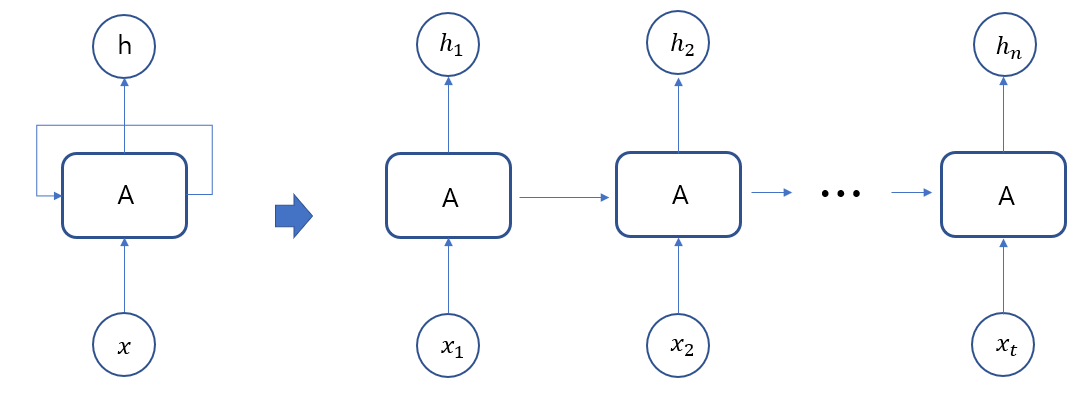

- 그림에서 보시면 x1에 대한 출력이 위쪽 화살표와 아래쪽 화살표 두 개인 것을 확인 할 수 있습니다. 즉, x1에 대한 정보가 h1 이라는 출력뿐만 아니라 다음 x2에 대한 정보와 같이 입력이 되는 구조입니다.

- 이 때 A에 해당하는 부분을 LSTM과 GRU 등을 사용하게 됩니다. 구조에서 보시다시피 RNN은 순차적인 구조이며 그 특징 때문에 연산에 많은 시간이 걸리rp 되고 네트워크의 고질적인 문제인 역전파 소실 문제가 발생합니다.

### **2) LSTM**

- 이제 LSTM이 RNN 구조에서 특정 시점의 정보를 다음 시점으로 전달할 때 얼만큼의 정보를 전달할지 결정하는 역할을 하겠다는 것을 유추할 수 있습니다.
- LSTM의 가장 큰 특징은 기존 RNN에 cell state를 추가한 것입니다. 이 cell state는 입력들의 정보를 선별하여 다음 출력으로 내보내는 게이트 역할을 합니다. 이 과정을 통해 불필요한 정보들을 걸러내어 매끄러운 진행이 가능하고 이로 인해 역전파 소실 문제를 줄여 성능이 증가하게 됩니다. LSTM은 상당히 복잡한 구조로 수식과 자세한 내용을 학습하고 싶으신 분은 여기를 참고하시기 바랍니다.

### **3) GRU**

- GRU는 LSTM의 복잡한 구조를 보다 간결하게 보완한 모델입니다. LSTM의 장점을 가져오면서 속도적인 부분을 개선하여 더욱 빠른 속도로 비슷한 성능을 낸다고 알려져 있습니다.

### **4)Attention**
- attention 매커니즘은 RNN 모델의 구조적인 한계를 극복한 모델입니다. RNN 모델을 활용하여 다음에 올 단어들을 예측하여 문장을 만드는 문제에 대해 생각해 보겠습니다. 다음 단어를 예측할 때 입력으로 받는 정보는 과연 무엇일까요?
- 네, 바로 지금까지 입력으로 집어넣었던 정보 모두와 예측 이전 단어입니다. 이런 경우 발생하는 문제점은 크게 다음의 두 가지 입니다.
  - 입력으로 이용된 정보들을 순차적으로 고정 길이로 압축하면서 발생하는 정보의 손실
  - 역전파 소실

- attention 매커니즘은 이러한 문제를 해결하기 위해 노력했고 다음과 같은 효과를 얻을 수 있습니다.

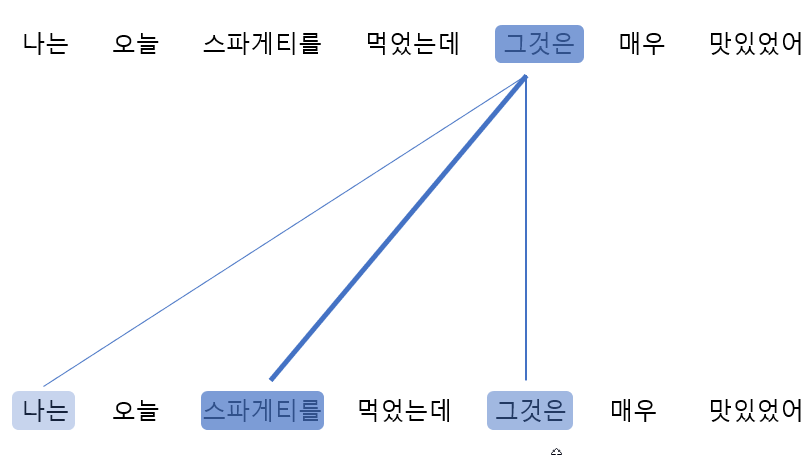

- 예시의 문장에서 "그것은" 이 무엇을 가리키는지 찾기 위해 attention을 이용하면 어떤 토큰의 정보가 가장 큰 도움을 줬는지 알 수 있습니다. 이것은 매우 직관적으로 축약한 내용이며 여기를 참조하시어 꼭 학습하시기 바랍니다.
- attention 매커니즘은 뒤이어 나온 자연어 처리의 세기적 발견인 Transformer(attention is all you need)의 핵심 알고리즘이며 이 둘에 대한 이해가 바탕이 되어야 다양한 문제에서 SOTA를 자랑하는 ELMO, BERT, GPT 등의 방법론들을 이해 할 수 있습니다.

## 5. 대회 적용

### **간단한 전처리 + 형태소 분석**

In [82]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-05-09 10:57:11--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-05-09 10:57:12--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc622bf4fa7ce9d714390982d653.dl.dropboxusercontent.com/cd/0/get/Bk4hMDjsykiFF63Xx-VrGeGKfdg33rcfZImRBRd-pfhjsGHolOKK0j2d_XDje_TpOf7rxzxmUnhJGBV0vRg8qWbW9w3cogoX9Wi7p2oYu1IJsbcTFn_qby2aT1pRpQcgTg1wwEZ36wckcQFfpG0ZN7v077A8euEVHW--Juy2EB3J_-1fmd9a2UvuXBeRtu-Qtr4/file?dl=1# [following]
--2022-05-09 10:57:12--  https://uc622bf4fa7ce9d714390982d653.dl.dropboxusercontent.com/cd/0/get/

In [83]:
from konlpy.tag import Okt

In [88]:
pip install tqdm

In [93]:
import tqdm
import re

In [94]:
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null']
    tokenizer = Okt()
    
    for text in tqdm.tqdm(text_list):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords or type(t) != float]
        
    return token, tokenizer

train = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/데이터/소설 작가 분류/train.csv')
train['token'], okt = text_preprocessing(train['text'])

100%|██████████| 54879/54879 [20:15<00:00, 45.16it/s]


ValueError: ignored

In [ ]:
import numpy as np
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_matrix에 저장합니다.
    else:
        print("word2vec에 없는 단어입니다.")
        break

In [ ]:
def LSTM(vocab_size, max_len=1000):
    model = Sequential()
    model.add(Embedding(vocab_size, 300,weights = [embedding_matrx], input_length = max_len)) #임베딩 가중치 적용 코드
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model